In [1]:
from zeroInf_negative_Binomial import *
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.pyplot import figure
from PIL import Image
import numpy as np
import seaborn as sns
import pandas as pd
from matplotlib import pyplot
from Utils.eval import multiProc_eval
from tensorflow.keras.optimizers import Adam
import keras.backend.tensorflow_backend
from keras.backend import clear_session
from tensorflow.keras.models import Model,Sequential
 

Num GPUs: 1


Using TensorFlow backend.


In [2]:
#model,checkpoint,modelpath,train,test = getModel()
source_model,modelpath,train,test = getModel(False)
source_model.summary()
predictions = source_model.layers[-2].output
model = Model(inputs=source_model.inputs, outputs=predictions)
model.summary()
#model = source_model

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 64, 64, 5)]  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 64, 64, 20)   920         input_1[0][0]                    
__________________________________________________________________________________________________
activation (Activation)         (None, 64, 64, 20)   0           conv2d[0][0]                     
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 32, 32, 20)   0           activation[0][0]                 
______________________________________________________________________________________________

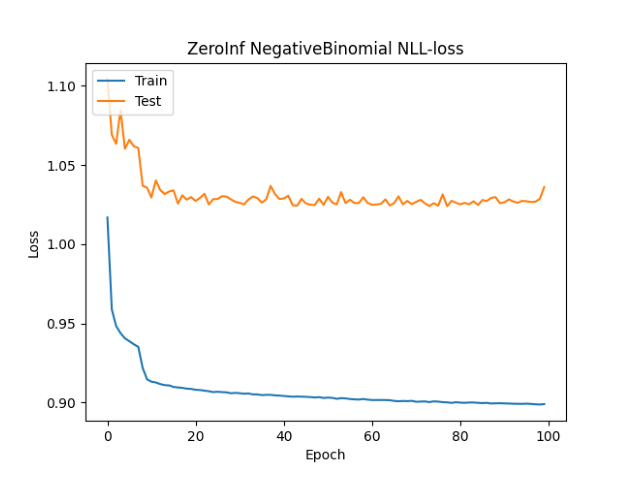

In [3]:
history_path = os.path.join(modelpath,MODELNAME+"_history.png")
figure(num=None, figsize=(10, 30), dpi=80, facecolor='w', edgecolor='k')
loss = np.array(Image.open(history_path))
plt.imshow(loss)
plt.axis('off')
plt.show()

In [4]:
history_path = os.path.join(modelpath,MODELNAME+"_history")
laststate = getBestState(modelpath,history_path)
epoch = laststate["epoch"]
model.load_weights(laststate["modelpath"])
test.setWiggle_off()
#loss = model.evaluate(x=test, verbose=2)
#print("Restored model, loss: {:5.5f} - epochs:{}".format(loss,epoch))

In [5]:
def getFreshSet(batch_size=1):
    x_transform = [Normalize(0.007742631458799244, 0.015872015890555563 )]
    
    train,test = getData(batch_size,
                         DIMENSION,CHANNELS,
                         timeToPred=10,
                         x_transform=x_transform)
    return train,test

In [6]:
from Models.Distributions import ZeroInflated_Binomial
pred = None
label = None
pred = 20
#test.on_epoch_end()
mean = []
stdev = []
label = []
predictions = []
train,test = getFreshSet(50)
test.on_epoch_end()
test.setWiggle_off()
atm = []
for x,y in test:
    for i in range(BATCH_SIZE):
        if y[i,:,:,:].max() >= 0:
            pred = model(np.array([x[i,:,:,:]]))
            pred = ZeroInflated_Binomial()(pred)
            mean.append(pred.mean())
            stdev.append(pred.stddev())
            label.append(y[i,:,:,:])
            predictions.append((pred,y[i:,:,:]))
            atm.append(x[i,:,:,-1:])
            if len(label) == 20:
                break
        break
    if len(label) == 20:
                break

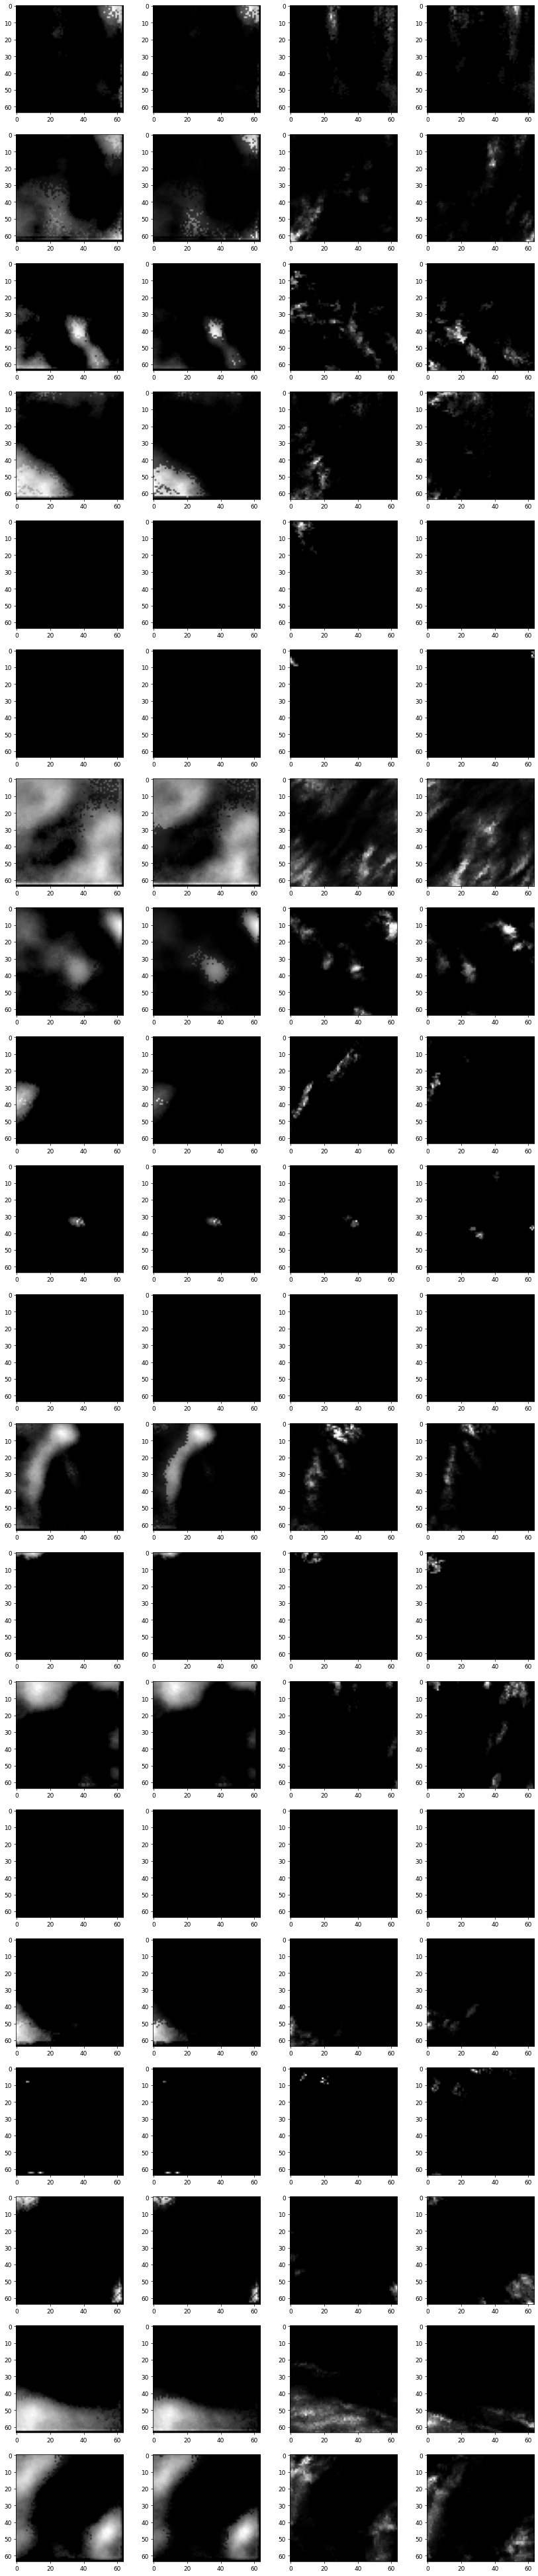

In [7]:
fig, axes = plt.subplots(20, 4, figsize=(16,8*10),dpi=64)
#fig.set_title(["mean","stdev","label"])
for batch,img in enumerate(mean):
    if batch == 20:
        break
    axes[batch,1].imshow(img[0,:,:,0],cmap="gray")
    axes[batch,0].imshow(stdev[batch][0,:,:,0],cmap="gray")
    axes[batch,2].imshow(label[batch][:,:,0],cmap="gray")
    axes[batch,3].imshow(atm[batch][:,:,0],cmap="gray")
plt.show()

In [8]:
train,test =  getFreshSet(batch_size=100)


In [9]:
baseline = multiProc_eval(model,test,getFreshSet)

Worker  0 finishedd   1800 imagesing to sleep for 5s
Worker  1 finishedd   1800 imagesing to sleep for 5s
Worker  4 finishedd   1800 imagesing to sleep for 5s
Worker  2 finishedd   1800 imagesing to sleep for 5s
Worker  3 finishedd   1800 imagesing to sleep for 5s
Worker  6 finishedd   1800 images
Worker  5 finishedd   1800 images
Worker 10 finishedd   1800 imagesing to sleep for 5s
Worker  7 finishedd   1800 images
Worker 11 finishedd   1800 images
Worker  9 finishedd   1800 images
Worker  8 finishedd   1800 images
Worker 12 finishedd   1800 images
Worker 14 finishedd   1800 images
Worker 13 finishedd   1800 images
Worker 15 finishedd   1800 images
Worker 17 finishedd   1800 images
Worker 16 finished
Worker 19 finishedd   1800 images
Worker 18 finishedd   1800 images
Worker 20 finishedd   1800 images
Worker 21 finishedd   1800 images
Worker 22 finishedd   1800 images
Worker 23 finishedd   1800 images
Worker 24 finishedd   1800 images
Worker 25 finishedd   1800 images
Worker 26 finishe

In [10]:
baseline_dict = baseline.copy()

<Figure size 800x1200 with 0 Axes>

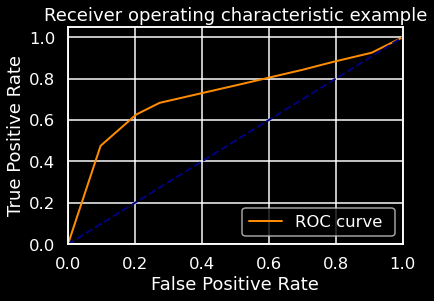

In [11]:
def plotAUC(baseline_dict,lw=2):
    figure(num=None, figsize=(10, 15), dpi=80, facecolor='w', edgecolor='k')
    tp = []
    fp = []
    
    for key in baseline_dict:
        base = baseline_dict[key]
        tp.append(base["TP"]/(base["TP"]+base["FN"]) )
        fp.append(base["FP"]/(base["FP"]+base["FN"]))
    sns.set(style="ticks", context="talk")
    sns.set_style("darkgrid")
    plt.style.use("dark_background")
    plt.figure()
    plt.plot(fp, tp, color='darkorange',
         lw=lw, label='ROC curve ')
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic example')
    plt.legend(loc="lower right")
    plt.show()
plotAUC(baseline_dict)

In [12]:
plt.figure(figsize = (4,4))

FN = baseline["FN"]
FP = baseline["FP"]
TN = baseline["TN"]
TP = baseline["TP"]

FP_s = baseline["FP_simple"]
FN_s = baseline["FN_simple"]
TP_s = baseline["TP_simple"]
TN_s = baseline["TN_simple"]


mat        = np.array([[TN  ,FP  ],[FN  ,TP  ]])
mat_simple = np.array([[TN_s,FP_s],[FN_s,TP_s]])

rain_total = baseline["rain total"]
total = baseline["total"]

df_cm = pd.DataFrame(mat/total,index = ["Actual 0","Actual 1"],columns=["Predicted 0","Predicted 1"])
sns.heatmap(df_cm, annot=True,vmin=0.0, vmax=1.0)
plt.show()



total = mat.sum()
df_cm = pd.DataFrame(mat_simple/total,index = ["Actual 0","Actual 1"],columns=["Predicted 0","Predicted 1"])
sns.heatmap(df_cm, annot=True,vmin=0.0, vmax=1.0)
plt.show()

print("Regen total: {}\nKein Regen total: {}\nVerhältnis: {:.4f}\n".format(rain_total,total-rain_total,rain_total/(total)))

print((mat_simple/total).sum(),(mat/total).sum(),total)
print(mat/total)
print(mat_simple/total)

KeyError: 'FN'

<Figure size 288x288 with 0 Axes>

In [ ]:
def quantile(prediction,iv = 256,cfdi = 0.95):
    shape = prediction.sample().shape
    q = np.zeros((*shape[:-1],3),dtype=np.float32)
    a         = np.arange(iv)
        
    prob = prediction.prob(a)
    cdf  = np.cumsum(prob,axis=-1)
    mean = prediction.mean()
    
    intervall = (cdf >= 1 - cfdi) & (cdf <=  cfdi)
    
    _,x,y,_ = shape
    
    x, y = np.meshgrid(np.arange(0,x),np.arange(0,y), sparse=False, indexing='ij')
    

    for i in range(shape[1]):
        for j in range(shape[2]):
            idcs   = np.where(intervall[0,i,j]==True)[0] 
            lower  = idcs[0]
            upper  = idcs[-1]
            q[0,i,j] = [lower,mean[0,i,j],upper]
            
            
    return q

In [ ]:
def dist(t):
    """
    d = tfd.Categorical(tf.stack([1-tf.math.sigmoid(t[...,0:1]),tf.math.sigmoid(t[...,0:1])],axis=-1))
    nb = tfp.distributions.NegativeBinomial(
                        total_count=tf.math.softplus(t[..., 1:2]), \
                        logits=tf.math.sigmoid(t[..., 2:]))
    return d,nb
    """
    return  tfp.distributions.Independent(
        tfd.Mixture(
            cat=tfd.Categorical(tf.stack([1-tf.math.sigmoid(t[...,:1]), tf.math.sigmoid(t[...,:1])],axis=-1)),
            components=[tfd.Deterministic(loc=tf.zeros_like(t[...,:1])),
            tfp.distributions.NegativeBinomial(
            total_count=tf.math.softplus(t[..., 1:2]), 
            logits=tf.math.sigmoid(t[..., 2:]) ),])
        ,name="ZeroInflated_Binomial",reinterpreted_batch_ndims=0 )

def dist2Classes(pred):
    
    zeros = np.zeros((*pred.shape[:-1],1))

    # Wahrscheinlichkeit für kein Regen
    pred = dist(pred)
    #pred = d(pred)
    
    rain = 1-np.array(pred.prob(0))
    
    # Wahrscheinlichkeit kein Regen größer 50%, 
    mask = (rain < 0.5)
    
    return mask



def labelToMask(label):
    # Gibt Maske mit kein Regen zurück
    return (label == 0)

true_pos = np.zeros((1,64,64,1))
true_neg = true_pos.copy()
false_pos = true_pos.copy()
false_neg = true_pos.copy()
rain_total = 0
total = 0

simple_true_pos = np.zeros((1,64,64,1))
simple_true_neg = true_pos.copy()
simple_false_pos = true_pos.copy()
simple_false_neg = true_pos.copy()
for i,(x,y) in enumerate(test):
    batchsize = y.shape[0]
    
    for batch in range(batchsize):
        print("{}/{}".format((i*batchsize)+batch,len(test)*batchsize),end="\r")
        with tf.device("/gpu:0"):
            pred = model(np.array([x[batch,:,:,:]]),training=False)
            

        pred_mask = dist2Classes(pred)
        labl_mask = labelToMask(y[batch,:,:,:])
        #              Kein Regen Predicted & Label = Kein Regen
        false_neg  += (pred_mask == True)    & (labl_mask == True)
        #              Regen Predicted       & Label = Kein Regen
        true_neg   += (pred_mask == False)   & (labl_mask == True)
        #              Regen Predicted       & Label = Regen
        true_pos   += (pred_mask == False)   & (labl_mask == False)
        #              Kein Regen Predicted  & Label = Regen
        false_pos  += (pred_mask == True)    & (labl_mask == False)
        rain_total += (~labl_mask).sum()
        total += labl_mask.sum() + (~labl_mask).sum()
        
        rain_atm = np.array(x[batch,:,:,-1])
        label_simple = labelToMask(rain_atm)
        
        # Simple Baseline
        
        rain_atm = x[batch,:,:,-1:]
        pred_simple = labelToMask(rain_atm)
        labl_mask = labelToMask(y[batch,:,:,:])
        
        
        
        
        
        #              Kein Regen Predicted & Label = Kein Regen
        simple_false_neg  += (pred_simple == True)    & (labl_mask == True)
        #              Regen Predicted       & Label = Kein Regen
        simple_true_neg   += (pred_simple == False)   & (labl_mask == True)
        #              Regen Predicted       & Label = Regen
        simple_true_pos   += (pred_simple == False)   & (labl_mask == False)
        #              Kein Regen Predicted  & Label = Regen
        simple_false_pos  += (pred_simple == True)    & (labl_mask == False)
        
        fig, axes = plt.subplots(1, 4, figsize=(16,8*10),dpi=64)
        axes[0].imshow(~(rain_atm[:,:,0] > 0),cmap="gray")
        axes[1].imshow(pred_simple[:,:,0],cmap="gray")
        axes[2].imshow(pred_mask[0,:,:,0],cmap="gray")
        axes[3].imshow(labl_mask[:,:,0],cmap="gray")
        plt.show()
    break
plt.figure(figsize = (4,4))

mat = np.array([[false_neg.sum(),false_pos.sum()],[true_neg.sum(),true_pos.sum()]])
total = mat.sum()
df_cm = pd.DataFrame(mat,index = ["Actual 0","Actual 1"],columns=["Predicted 0","Predicted 1"])
sns.heatmap(df_cm, annot=True,vmin=0.0, vmax=1.0)
plt.show()

plt.figure(figsize = (4,4))
print("Simple Baseline")
mat_simple = np.array([[simple_false_neg.sum(),simple_false_pos.sum()],[simple_true_neg.sum(),simple_true_pos.sum()]])
total = mat.sum()
df_cm = pd.DataFrame(mat_simple,index = ["Actual 0","Actual 1"],columns=["Predicted 0","Predicted 1"])
sns.heatmap(df_cm, annot=True,vmin=0.0, vmax=1.0)
plt.show()

In [ ]:
plt.figure(figsize = (4,4))
print("Simple Baseline")
mat_simple = np.array([[simple_false_neg.sum(),simple_false_pos.sum()],[simple_true_neg.sum(),simple_true_pos.sum()]])
total = mat.sum()
df_cm = pd.DataFrame(mat_simple/total,index = ["Actual 0","Actual 1"],columns=["Predicted 0","Predicted 1"])
sns.heatmap(df_cm, annot=True,vmin=0.0, vmax=1.0)
plt.show()

In [ ]:
predictions = []
quantiles = []
l = 0
length = len(test)
cdfi = 0.95
print("Calculating [{:.2f},{:.2f}] quantiles: ".format(1-cdfi,cdfi))
for x,y in test:
    
    print("{:6d}/{:6d}".format(l,length),end="\r")
    l+= y.shape[0]
    
    pred = model(np.array([x[0,:,:,:]]))
    predictions.append((pred,y[0:,:,:]))
        #quantiles = [(quantile(pred,cfdi=0.95),y) for pred,y in predictions ]
    quantiles.append((quantile(pred,cfdi=cdfi),y))


    if l == 400:
        break
    

In [ ]:
x,y     = (32,32)
label   = []
mean    = []
q_lower = []
q_upper = []
time    = []
for i,p in enumerate(quantiles):
    q_l,m,q_u = p[0][0,x,y]
    l_true    = p[1][0,x,y]
    q_lower.append(q_l)
    q_upper.append(q_u)
    mean.append(m)
    label.append(l_true[0])
    time.append(i)



In [ ]:
d = {"time":time,"{:.2f}".format(1-cdfi):q_lower,"{:.2f}".format(cdfi):q_upper,"mean":mean,"label":label}
data = pd.DataFrame(d)
data = data[:400]

a4_dims = (100, 15)

fig, ax = pyplot.subplots(figsize=a4_dims)

sns.set(style="darkgrid")
sns.lineplot(x="time", y="mean",
             data=data)

sns.lineplot(x="time", y="0.95",
             data=data)

sns.lineplot(x="time", y="label",
             data=data)

In [ ]:
plt.figure(figsize = (4,4))

mat = np.array([[false_neg.sum(),false_pos.sum()],[true_neg.sum(),true_pos.sum()]])
total = mat.sum()
df_cm = pd.DataFrame(mat/total,index = ["Actual 0","Actual 1"],columns=["Predicted 0","Predicted 1"])
sns.heatmap(df_cm, annot=True,vmin=0.0, vmax=1.0)
plt.show()

In [ ]:
plt.figure(figsize = (4,4))
print("Simple Baseline")
mat_simple = np.array([[simple_false_neg.sum(),simple_false_pos.sum()],[simple_true_neg.sum(),simple_true_pos.sum()]])
total = mat.sum()
df_cm = pd.DataFrame(mat_simple/total,index = ["Actual 0","Actual 1"],columns=["Predicted 0","Predicted 1"])
sns.heatmap(df_cm, annot=True,vmin=0.0, vmax=1.0)
plt.show()

In [ ]:
print("Regen total: {}\nKein Regen total: {}\nVerhältnis: {:.4f}\n".format(rain_total,total-rain_total,rain_total/(total)))